Load modules

In [2]:
%load_ext autoreload
%matplotlib inline

In [3]:
%autoreload 2

from IPython import display
from utils import Logger 

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import trimesh
import trimesh.voxel.creation
import rtree

In [4]:
from torch.utils.data import Dataset

In [5]:
import scipy.ndimage as ndimage

load .obj files

In [6]:
data_folder='./inputs'

In [53]:
meshes = [trimesh.load_mesh('./inputs/s3.obj'),trimesh.load_mesh('./inputs/s4.obj'),trimesh.load_mesh('./inputs/s5.obj')]#,trimesh.load_mesh('./inputs/s6.obj')]
type(meshes)

faces have mixed data, using slow fallback!
faces have mixed data, using slow fallback!
faces have mixed data, using slow fallback!


list

Reshape tensors with padding

In [9]:
# Define size of the space (pix)
scene_size = 32 

In [54]:
# convert to tensors
vox_meshes = []
for m in range(len(meshes)):
    voxelized= trimesh.voxel.creation.voxelize(meshes[m],0.3)
    matrix = torch.from_numpy(voxelized.matrix) 
    target = torch.zeros(scene_size,scene_size,scene_size)
    source = torch.ones(matrix.shape)
    target[:source.size(0), :source.size(1), :source.size(2)] = source
    vox_meshes.append(target.reshape([1,scene_size,scene_size,scene_size]))

In [11]:
vox_meshes[0].shape #check

torch.Size([1, 32, 32, 32])

In [55]:
#dataset class
class object_dataset(Dataset):
    def __init__(self):
        self.samples = vox_meshes

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [56]:
train_set = object_dataset() #load the data

In [57]:
#Create dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=3, shuffle=True) 

In [58]:
num_batches=len(train_loader)


### My Networks

In [16]:
class DiscriminatorNet(torch.nn.Module):
    
    #3 hidden-layer discriminative nn
    
    def __init__(self, scene_size = 32):
        super(DiscriminatorNet, self).__init__()
        self.n_features = scene_size * scene_size * scene_size
        self.n_out=1
        self.scene_size = scene_size
        
        pad = (1,1,1)
        
        self.conv1 = nn.Sequential(
            torch.nn.Conv3d(1, self.scene_size, kernel_size=4, stride=2, bias=False, padding= pad),
            torch.nn.BatchNorm3d(self.scene_size),
            torch.nn.LeakyReLU(0.2)
        )
        
        self.conv2 = nn.Sequential(
        torch.nn.Conv3d(self.scene_size,self.scene_size*2,kernel_size=4,stride=2,bias=False,padding=pad),
        torch.nn.BatchNorm3d(self.scene_size*2),
        torch.nn.LeakyReLU(0.2)
        )
        
        self.conv3 = nn.Sequential(
        torch.nn.Conv3d(self.scene_size*2, self.scene_size*4,kernel_size=4,stride=2, bias=False, padding= pad),
        torch.nn.BatchNorm3d(self.scene_size*4),
        torch.nn.LeakyReLU(0.2)
        )
        
        self.conv4 =  nn.Sequential(
        torch.nn.Conv3d(self.scene_size*4,self.scene_size*8,kernel_size=4, stride=2, bias=False, padding= pad),
        torch.nn.BatchNorm3d(self.scene_size*8),
        torch.nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
        torch.nn.Conv3d(self.scene_size*8,self.n_out,kernel_size=4, stride=2, bias=False, padding= pad),
        torch.nn.Sigmoid()
        )

        
    def forward(self, x):
        x = x.view(-1, 1, self.scene_size, self.scene_size, self.scene_size)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        return x

        


In [38]:
class GeneratorNet(torch.nn.Module):
    
    #3 hidden-layer discriminative nn
    
    def __init__(self, scene_size = 32, n_features = 64):
        super(GeneratorNet, self).__init__()
        self.scene_size = scene_size
        self.n_features = n_features
        self.n_out=1
        
        
        pad = (1,1,1)
        
        self.conv1 = nn.Sequential(
            torch.nn.ConvTranspose3d(self.n_features, self.scene_size * 8, kernel_size=4, stride=2, bias=False, padding= pad),
            torch.nn.BatchNorm3d(self.scene_size*8),
            torch.nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size*8,self.scene_size*4,kernel_size=4,stride=2,bias=False,padding=pad),
        torch.nn.BatchNorm3d(self.scene_size*4),
        torch.nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size*4, self.scene_size*2,kernel_size=4,stride=2, bias=False, padding= pad),
        torch.nn.BatchNorm3d(self.scene_size*2),
        torch.nn.ReLU()
        )
        
        self.conv4 =  nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size*2,self.scene_size,kernel_size=4, stride=2, bias=False, padding= pad),
        torch.nn.BatchNorm3d(self.scene_size),
        torch.nn.ReLU()
        )
        
        self.out = nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size,self.n_out,kernel_size=4, stride=2, bias=False, padding= pad),
        torch.nn.Sigmoid()
        )

        
    def forward(self, x):
        x = x.view(-1, self.n_features, 1,1,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        return x

        


Flatten inputs

In [18]:
def vox_to_vectors(vox):
    return vox.view(vox.size(0),scene_size*scene_size*scene_size)

def vectors_to_vox(vectors):
    return vectors.view(vectors.size(0),1,scene_size,scene_size,scene_size)

Function to generate sample noise

In [33]:
def noise(size):
    #1-d vector of gaussian sampled random values
    
    n= Variable(torch.randn(size,64))
    #pass to the GPU
    if torch.cuda.is_available(): return n.cuda()
    return n

In [20]:
n=noise(30)
n.shape

torch.Size([30, 100])

In [39]:
discriminator = DiscriminatorNet()
generator = GeneratorNet() 

if  torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

We also need some additional functionality that allows us to create the random noise. The random noise will be sampled from a normal distribution with mean 0 and variance 1

we’ll use Adam as the optimization algorithm for both neural networks

### Optimization

In [40]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

Loss function

In [131]:
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1

# Number of epochs
num_epochs = 400

Real and fake labels

In [24]:
def real_data_target(size):
    
    # Tensor containing ones(real)
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    
    # Tensor containing ones(fake)    
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [153]:
def train_discriminator(optimizer , real_data , fake_data):
    
    N = real_data.size(0)
    
    #need to zero gradients
    optimizer.zero_grad()
    
    #train on real data
    prediction_real = discriminator(real_data)
    
    #calculate error and backpropagate
    error_real = loss(prediction_real,real_data_target(N).reshape([3, 1, 1, 1, 1]))
    error_real.backward()
    
    #train on fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake,fake_data_target(N).reshape([3, 1, 1, 1, 1]))
    error_fake.backward()
    
    optimizer.step()
    
    #return error and prdictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)).reshape([3, 1, 1, 1, 1]))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error



Samples

In [154]:
num_test_samples = 1
test_noise = noise(num_test_samples)

### Training

In [26]:
for i, loader_data in enumerate(train_loader):
    print(type(loader_data))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [158]:
logger = Logger(model_name='VoxGAN', data_name='myModels')

for epoch in range(num_epochs):
    for n_batch, real_batch in  enumerate(train_loader):
       
        # 1. Train Discriminator
        real_data = Variable(vox_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        #print(fake_data.shape)
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,real_data, fake_data)
      
        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        #print(real_batch.shape)
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        #display
        #test_vox = vectors_to_vox(generator(test_noise)).data.cpu()
        
            
        # Display status Logs
        if epoch%20 == 0:
            logger.display_status(
            epoch, num_epochs, n_batch, num_batches,
            d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
            logger.save_models(generator, discriminator, epoch)

Epoch: [0/400], Batch Num: [0/1]
Discriminator Loss: 0.1599, Generator Loss: 2.7186
D(x): 0.9362, D(G(z)): 0.0862


KeyboardInterrupt: 

In [ ]:
test_vox[0]

In [145]:
vox_to_display = fake_data.cpu().data.squeeze().numpy()
vox_to_display[0] 

array([[[1.06049299e-01, 5.57046868e-02, 6.86431378e-02, ...,
         6.09231368e-03, 5.44693647e-03, 4.40536104e-02],
        [5.32854125e-02, 7.60154426e-03, 3.23457620e-03, ...,
         1.60310243e-04, 5.52272431e-05, 1.90275756e-03],
        [5.93848452e-02, 3.64585891e-02, 1.91748049e-02, ...,
         5.06106939e-04, 1.17229698e-04, 3.80047341e-03],
        ...,
        [2.43110233e-03, 7.45675352e-05, 1.08980466e-05, ...,
         2.05212229e-04, 3.52440184e-05, 1.82960648e-03],
        [4.92781354e-03, 1.06118365e-04, 1.54514477e-04, ...,
         2.80498061e-04, 1.56094990e-04, 3.11049097e-03],
        [1.72820985e-02, 2.23653414e-03, 7.39154697e-04, ...,
         3.24591133e-03, 1.47602591e-03, 1.77684445e-02]],

       [[4.25773747e-02, 2.25133859e-02, 2.80847698e-02, ...,
         8.32102887e-05, 6.44345928e-05, 1.73368142e-03],
        [7.23860562e-02, 4.57674451e-02, 7.78958142e-01, ...,
         1.36437920e-05, 3.80437414e-05, 2.03099829e-04],
        [6.85873777e-02, 

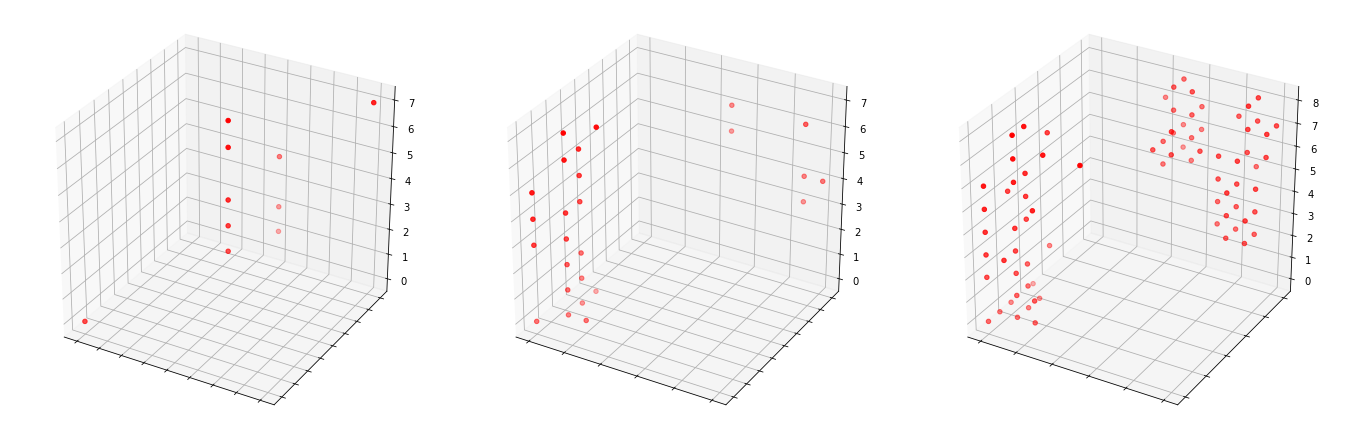

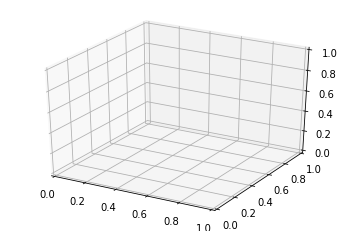

In [161]:
#I CAN FIND THE POSITIONS OF THE NON-ZERO ELEMENTS...CAN I USE THIS?

#get the values > number
voxels = vox_to_display.__ge__(0.1)
fig = plt.figure(figsize=(32, 16))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.05, hspace=0.05)

#print(voxels)
for i, sample in enumerate(voxels):
        #print(sample.shape)
        s = sample.nonzero()#.reshape([3,27000])
        #print(s)
        x,y,z = s
        
        ax = plt.subplot(gs[i], projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        #ax.set_aspect('equal')
#plt.savefig(path + '{}.png'.format(str(iteration).zfill(3)), bbox_inches='tight')
#plt.close()

fig = plt.figure()
ax = fig.gca(projection='3d')

#print(test_vox[0].shape)
#v=test_vox[0].squeeze()#.reshape([3,8000])
#print(v.shape)
#ax.voxels(v)
plt.show()

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

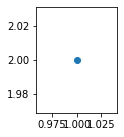

In [54]:
sc = np.array([[10,10],[10,10]])

ax = plt.subplot(gs[i])
ax.scatter(1,2)

ValueError: Argument filled must be 3-dimensional

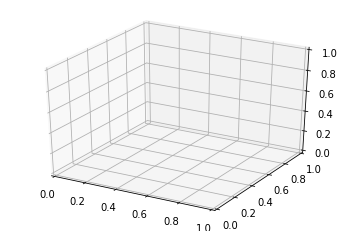

In [38]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(test_vox, edgecolor="red")
plt.show()
#ax.set_aspect('equal')

In [ ]:
test_vox[0].squeeze()